# A Sudoku Problem formulated as an LP

## Problem Description

A sudoku problem is a problem where there are is an incomplete 9x9 table of numbers which must be filled according to several rules:
- Within any of the 9 individual 3x3 boxes, each of the numbers 1 to 9 must be found
- Within any column of the 9x9 grid, each of the numbers 1 to 9 must be found
- Within any row of the 9x9 grid, each of the numbers 1 to 9 must be found
On this notebook we will formulate the below problem from wikipedia to model using PuLP. Once created, our code will need little modification to solve any sudoku problem at all.

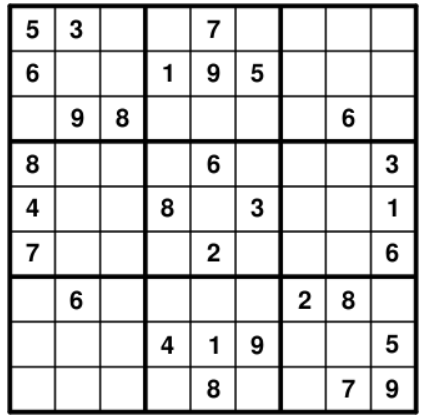

You may see the original problem description and solution by *Antony Phillips and Dr Stuart Mitcehll* here:  
https://pythonhosted.org/PuLP/CaseStudies/a_sudoku_problem.html

## Identifying the Decision Variables

In order to formulate this problem as a linear program, we cannot simply create a variable for each of the 81 squares between 1 and 9 representing the value in that square. This is because in linear programming there is no “not equal to” operator and so we cannot use the necessary constraints of no squares within a box/row/column being equal in value to each other. Whilst we can ensure the sum of all the values in a box/row/column equal 45, this will still result in many solutions satisfying the 45 constraint but still with 2 of the same number in the same box/row/column.


Instead, we must create 729 individual binary (0-1) problem variables. These represent 9 problem variables per square for each of 81 squares, where the 9 variables each correspond to the number that might be in that square. The binary nature of the variable says whether the existence of that number in that square is true or false. 

Therefore, there can clearly be only 1 of the 9 variables for each square as true (1) and the other 8 must be false (0) since only one number can be placed into any square. This will become more clear.

## The Objective Function

Interestingly, with sudoku **there is no solution that is better than another solution**, since a solution by definition, must satisfy all the constraints. 

Therefore, we are not really trying to minimise or maximise anything, we are just trying to find the values on our variables that satisfy the constraints. Therefore, whilst either LpMinimize or LpMaximize must be entered, it is not important which. Similarly, the objective function can be anything, so in this example it is simply zero. That is we are trying to minimize zero, subject to our constraints (meeting the constraints being the important part)

In [22]:
"""
The Sudoku Problem Formulation for the PuLP Modeller using NumPy

Authors: Cesar
"""

from pulp import LpVariable, LpBinary, LpInteger, LpProblem
import pandas as pd
import numpy as np

We start by creating a 9x9x9 numpy array to hold our 729 variables, as described above.

In [23]:
table = np.zeros((9,9,9), dtype='object')

Within this 3 dimensional array, first dimension represents dummy variables for each digit, and second and third dimensions represent rows and columns (boxes as well)

In [24]:
for i in range(1,10):
    for j in range(1,10):
        for k in range(1,10):
            table[i-1,j-1,k-1] = LpVariable(f'X_{i}_{j}_{k}', 0, 1, LpInteger)

In [25]:
prob = LpProblem('sudoku')

There is no solution better than another if constraints are satisfied.

Therefore, optimization objective is added as `0`.

In [26]:
prob += 0

### Constraints

- There cannot be more than one occurences of the same digit within the same box:

In [27]:
# Boxes:

for i in [0,3,6]:
    for j in [0,3,6]:
        for k in range(9):
            prob += table[k, i:i+3, j:j+3].sum() == 1

- There cannot be more than one occurences of the same digit within the same row and column.
- There has to be only one digit per place.

In [28]:
for i in range(9):
    for j in range(9):
        # Columns:
        prob += table[i, j, :].sum() == 1
        # Rows
        prob += table[i, :, j].sum() == 1
        # One digit per place
        prob += table[:, i, j].sum() == 1
     

Finally, we define constraints for already given digits in puzzle.  

Note that we are inserting digit - 1 to adjust numpy's indexing.

In [29]:
   
prob += table[4, 0, 0] == 1
prob += table[5, 1, 0] == 1
prob += table[7, 3, 1] == 1
prob += table[3, 4, 0] == 1

Some of the given digits are omitted to keep the code concise.

In [30]:
prob.writeLP('../LP-Files/sudoku.lp')

In [31]:
prob.solve()

1

To print the solution in a presentable way, a new array is defined just like the 3D `tables` array.

In [32]:
sol = np.zeros_like(table)

Solved variable values are copied to this new array.

In [33]:
for i in range(9):
    for j in range(9):
        for k in range(9):
            sol[i,j,k] = table[i,j,k].value()

In [34]:
a = sol.argmax(axis=0)+1
a

array([[5, 9, 8, 7, 4, 2, 1, 6, 3],
       [6, 3, 4, 1, 8, 5, 9, 2, 7],
       [2, 1, 7, 9, 6, 3, 5, 4, 8],
       [7, 8, 1, 5, 9, 4, 6, 3, 2],
       [4, 2, 6, 3, 1, 8, 7, 5, 9],
       [9, 5, 3, 6, 2, 7, 8, 1, 4],
       [3, 7, 9, 4, 5, 1, 2, 8, 6],
       [8, 4, 5, 2, 7, 6, 3, 9, 1],
       [1, 6, 2, 8, 3, 9, 4, 7, 5]], dtype=int64)

Checking row constraints:

In [35]:
a.sum(axis=0)

array([45, 45, 45, 45, 45, 45, 45, 45, 45], dtype=int64)

Checking column constraints:

In [36]:
a.sum(axis=1)

array([45, 45, 45, 45, 45, 45, 45, 45, 45], dtype=int64)

Checking box constraints:

In [37]:
a.reshape(9,3,3).sum(axis=0)

array([[45, 45, 45],
       [45, 45, 45],
       [45, 45, 45]], dtype=int64)